In [1]:
# Don't do this. Do as I say and not as I code.
import sys
sys.path.insert(0, "../") 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import stan_utils as stan
from data_utils import (generate_data, test_data)
from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [15]:
seed = 42

data_kwds = dict(N=1000, D=10, J=3, K=5, seed=seed, full_output=True)
data, truths = generate_data(**data_kwds)

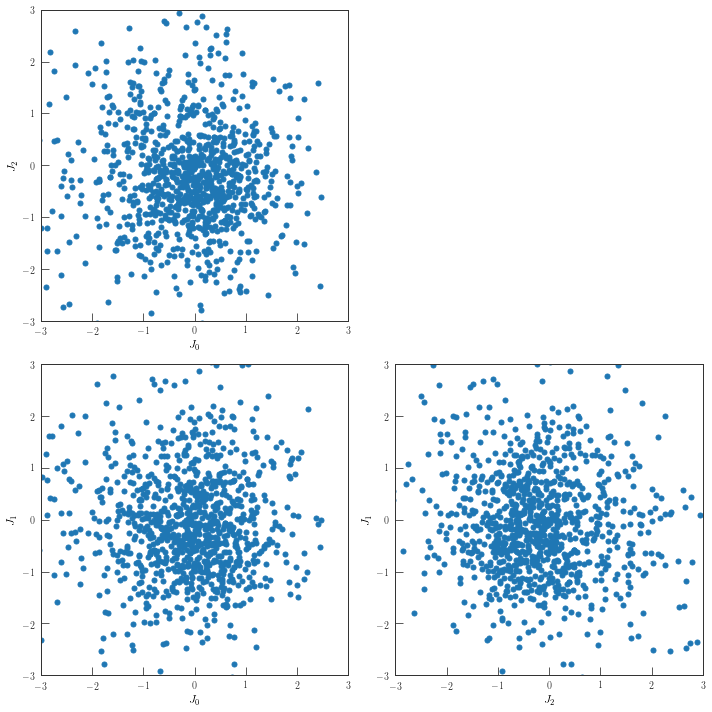

In [16]:
K = 2
fig, axes = plt.subplots(K, K, figsize=(10, 10))

axes[1, 0].scatter(truths["theta"].T[0], truths["theta"].T[1])
axes[1, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[1, 0].set_ylabel(r"$J_{{{0}}}$".format(1))

axes[0, 0].scatter(truths["theta"].T[0], truths["theta"].T[2])
axes[0, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[0, 0].set_ylabel(r"$J_{{{0}}}$".format(2))

axes[0, 1].set_visible(False)
axes[1, 1].scatter(truths["theta"].T[2], truths["theta"].T[1])
axes[1, 1].set_xlabel(r"$J_{{{0}}}$".format(2))
axes[1, 1].set_ylabel(r"$J_{{{0}}}$".format(1))

for ax in np.array(axes).flatten():
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
fig.tight_layout()


In [17]:
# Optimize 
op_kwds = dict(init_alpha=1, tol_obj=1e-16, tol_rel_grad=1e-16, 
    tol_rel_obj=1e-16)
op_kwds = dict(data=data, seed=seed)

model = stan.load_stan_model("../mlf.stan")

s_opt = model.optimizing(**op_kwds)

INFO:root:Using pre-compiled model from ../mlf.stan.cached
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0.05800301643406369, 1.6594741002445121)

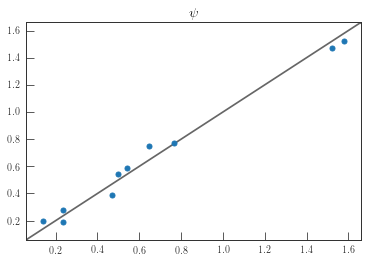

In [18]:
fig, ax = plt.subplots()
ax.scatter(np.diag(truths["psi"]), s_opt["psi"])
ax.set_title(r"$\psi$")
limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
limits = np.array([limits.min(), limits.max()])
ax.plot(limits, limits, c="#666666", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

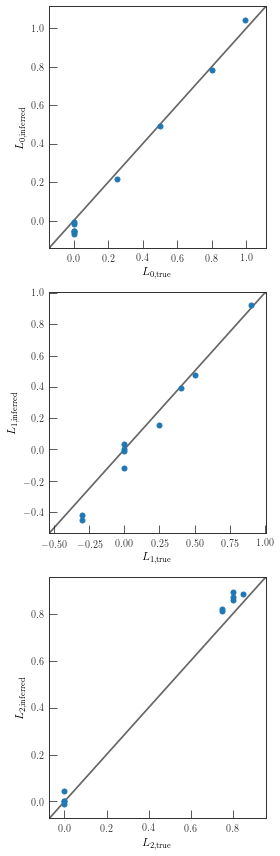

In [19]:
fig, axes = plt.subplots(truths["L"].shape[0], figsize=(4, 12))
for i, ax in enumerate(axes):
    ax.scatter(truths["L"][i], s_opt["L"].T[i])

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([limits.min(), limits.max()])
    ax.plot(limits, limits, c="#666666", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel(r"$L_{{{0},\textrm{{true}}}}$".format(i))
    ax.set_ylabel(r"$L_{{{0},\textrm{{inferred}}}}$".format(i))

fig.tight_layout()

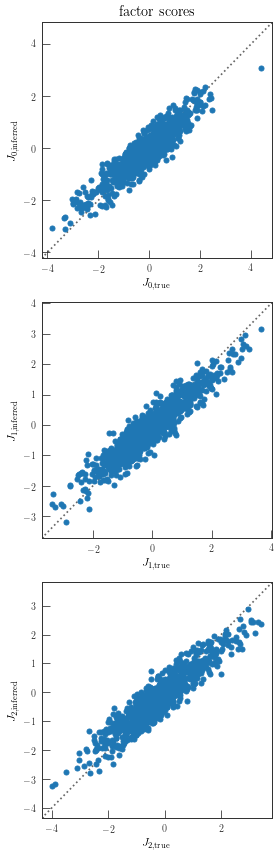

In [20]:
y = data["y"]
N, D = y.shape

factor_loads = s_opt["L"].T

b = factor_loads/np.sqrt(s_opt["psi"])
scaled_y = y/np.sqrt(s_opt["psi"])

b_sq = np.sum(b**2, axis=1)
N, J = truths["theta"].shape
factor_scores = np.dot(scaled_y, b.T) * (1 - J/(N - 1) * b_sq)/(1 + b_sq)

fig, axes = plt.subplots(J, figsize=(4, 12))
for j, ax in enumerate(axes):
    ax.scatter(truths["theta"].T[j], factor_scores.T[j])

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([np.min(limits), np.max(limits)])
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel(r"$J_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$J_{{{0},\textrm{{inferred}}}}$".format(j))

axes[0].set_title(r"\textrm{factor scores}")
fig.tight_layout()
    

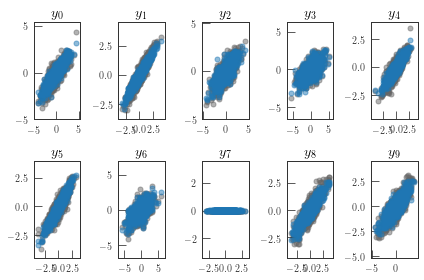

In [21]:
fig, axes = plt.subplots(2, 5)
axes = np.array(axes).flatten()

faux_y = np.dot(factor_scores, factor_loads)
true_y = np.dot(truths["theta"], truths["L"])

for i, ax in enumerate(axes):
    ax.scatter(y.T[i], faux_y.T[i], alpha=0.5)
    ax.scatter(y.T[i], true_y.T[i], facecolor="#666666", zorder=-1, alpha=0.5)

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([limits.min(), limits.max()])
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_title(r"$y_{{{0}}}$".format(i))
    
fig.tight_layout()


In [67]:
# Let's make things much clumpier.
seed = 123

data_kwds = dict(N=1000, D=10, J=3, K=10, seed=seed, full_output=True,
                __cluster_scale=0.01)
data, truths = generate_data(**data_kwds)


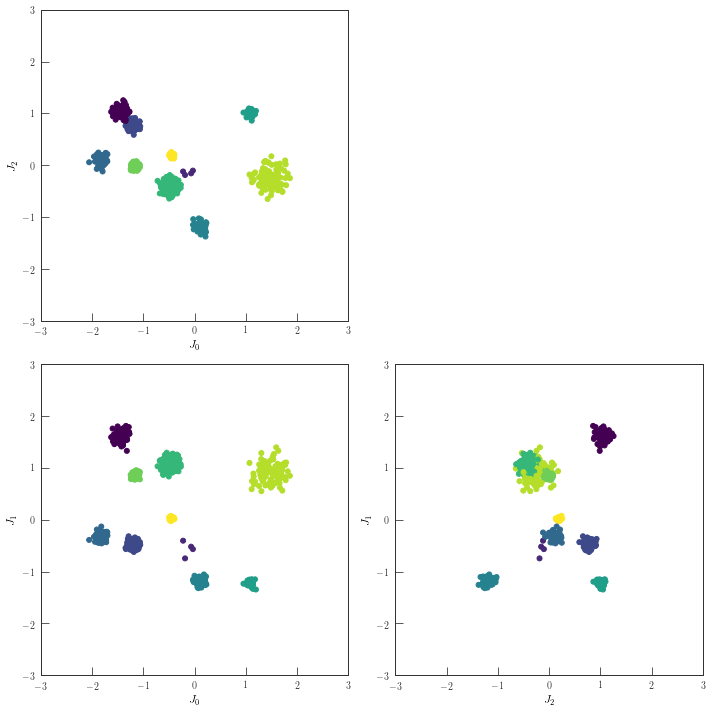

In [68]:
K = 2
fig, axes = plt.subplots(K, K, figsize=(10, 10))

axes[1, 0].scatter(truths["theta"].T[0], truths["theta"].T[1],
                   c=truths["responsibility"])
axes[1, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[1, 0].set_ylabel(r"$J_{{{0}}}$".format(1))

axes[0, 0].scatter(truths["theta"].T[0], truths["theta"].T[2],
                   c=truths["responsibility"])
axes[0, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[0, 0].set_ylabel(r"$J_{{{0}}}$".format(2))

axes[0, 1].set_visible(False)
axes[1, 1].scatter(truths["theta"].T[2], truths["theta"].T[1],
                   c=truths["responsibility"])
axes[1, 1].set_xlabel(r"$J_{{{0}}}$".format(2))
axes[1, 1].set_ylabel(r"$J_{{{0}}}$".format(1))

for ax in np.array(axes).flatten():
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
fig.tight_layout()


In [69]:
# Optimize 
op_kwds = dict(init_alpha=1, tol_obj=1e-16, tol_rel_grad=1e-16, 
    tol_rel_obj=1e-16)
op_kwds = dict(data=data, seed=seed)

model = stan.load_stan_model("../mlf.stan")

s_opt = model.optimizing(**op_kwds)

INFO:root:Using pre-compiled model from ../mlf.stan.cached
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0.14419330975035657, 2.6882485074012568)

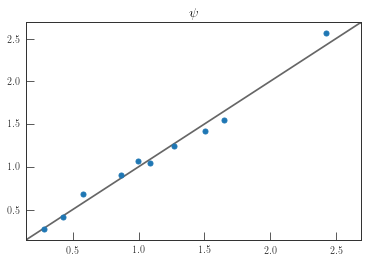

In [70]:
fig, ax = plt.subplots()
ax.scatter(np.diag(truths["psi"]), s_opt["psi"])
ax.set_title(r"$\psi$")
limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
limits = np.array([limits.min(), limits.max()])
ax.plot(limits, limits, c="#666666", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

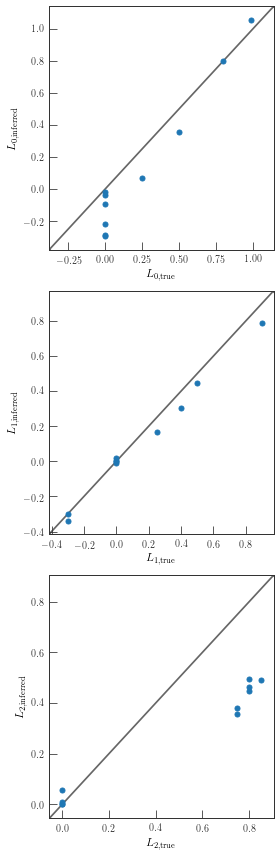

In [71]:
fig, axes = plt.subplots(truths["L"].shape[0], figsize=(4, 12))
for i, ax in enumerate(axes):
    ax.scatter(truths["L"][i], s_opt["L"].T[i])

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([limits.min(), limits.max()])
    ax.plot(limits, limits, c="#666666", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel(r"$L_{{{0},\textrm{{true}}}}$".format(i))
    ax.set_ylabel(r"$L_{{{0},\textrm{{inferred}}}}$".format(i))

fig.tight_layout()

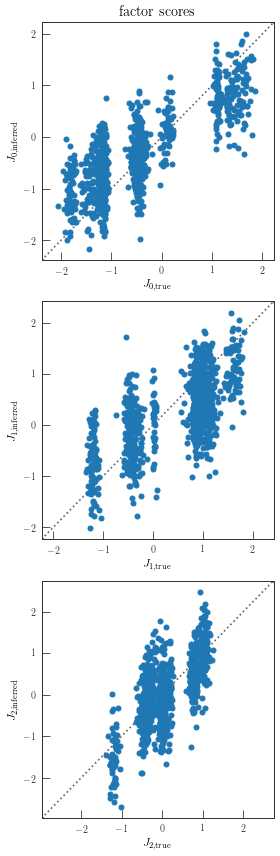

In [72]:
y = data["y"]
N, D = y.shape

factor_loads = s_opt["L"].T

b = factor_loads/np.sqrt(s_opt["psi"])
scaled_y = y/np.sqrt(s_opt["psi"])

b_sq = np.sum(b**2, axis=1)
N, J = truths["theta"].shape
factor_scores = np.dot(scaled_y, b.T) * (1 - J/(N - 1) * b_sq)/(1 + b_sq)

fig, axes = plt.subplots(J, figsize=(4, 12))
for j, ax in enumerate(axes):
    ax.scatter(truths["theta"].T[j], factor_scores.T[j])

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([np.min(limits), np.max(limits)])
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel(r"$J_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$J_{{{0},\textrm{{inferred}}}}$".format(j))

axes[0].set_title(r"\textrm{factor scores}")
fig.tight_layout()
    

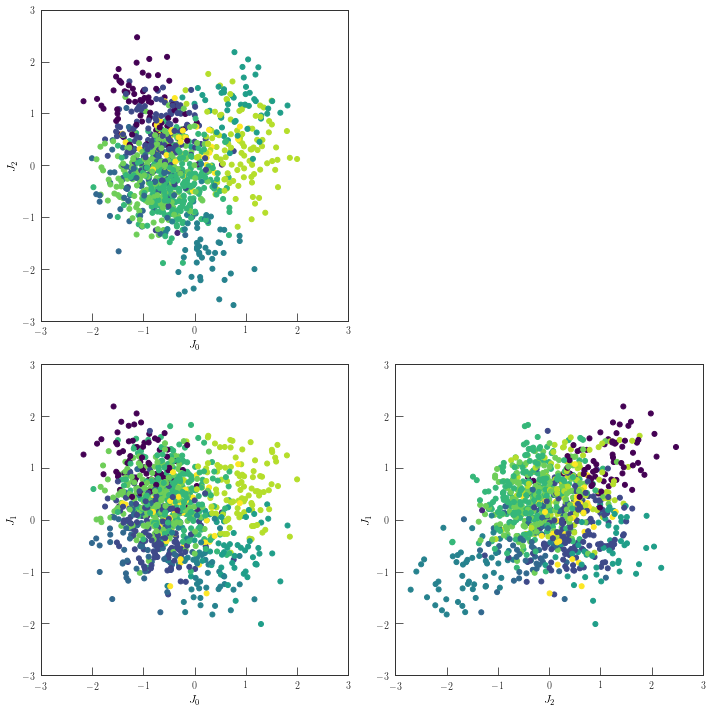

In [73]:
K = 2
fig, axes = plt.subplots(K, K, figsize=(10, 10))

axes[1, 0].scatter(factor_scores.T[0], factor_scores.T[1],
                   c=truths["responsibility"])
axes[1, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[1, 0].set_ylabel(r"$J_{{{0}}}$".format(1))

axes[0, 0].scatter(factor_scores.T[0], factor_scores.T[2],
                   c=truths["responsibility"])
axes[0, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[0, 0].set_ylabel(r"$J_{{{0}}}$".format(2))

axes[0, 1].set_visible(False)
axes[1, 1].scatter(factor_scores.T[2], factor_scores.T[1],
                   c=truths["responsibility"])
axes[1, 1].set_xlabel(r"$J_{{{0}}}$".format(2))
axes[1, 1].set_ylabel(r"$J_{{{0}}}$".format(1))

for ax in np.array(axes).flatten():
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
fig.tight_layout()


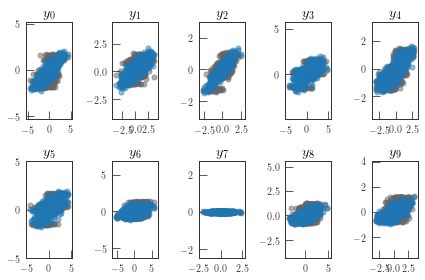

In [74]:
fig, axes = plt.subplots(2, 5)
axes = np.array(axes).flatten()

faux_y = np.dot(factor_scores, factor_loads)
true_y = np.dot(truths["theta"], truths["L"])

for i, ax in enumerate(axes):
    ax.scatter(y.T[i], faux_y.T[i], alpha=0.5)
    ax.scatter(y.T[i], true_y.T[i], facecolor="#666666", zorder=-1, alpha=0.5)

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([limits.min(), limits.max()])
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_title(r"$y_{{{0}}}$".format(i))
    
fig.tight_layout()


In [75]:
# Just run a GMM w/ BIC on factor scores (true and inferred)
# to see how it behaves
from sklearn import mixture

n_clusters = np.arange(1, data["K"] + 5)
truth_bics = np.ones_like(n_clusters)
inferred_bics = np.ones_like(n_clusters)


for i, nc in enumerate(n_clusters):
    
    Xs = (truths["theta"], factor_scores)
    bics = (truth_bics, inferred_bics)
    
    for X, b in zip(Xs, bics):
        gmm = mixture.GaussianMixture(n_components=nc,
                                      covariance_type="spherical")
        gmm.fit(X)
        b[i] = gmm.bic(X)
    



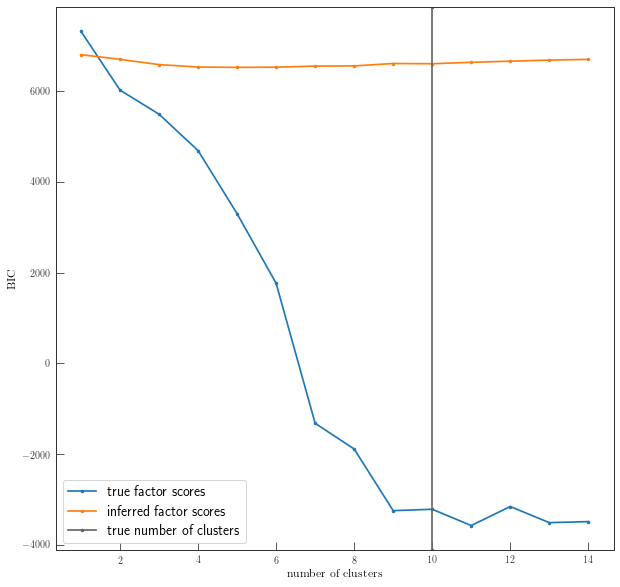

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(n_clusters, truth_bics, label="true factor scores")
ax.plot(n_clusters, inferred_bics, label="inferred factor scores")
ax.axvline(data["K"], c="#666666", label="true number of clusters")
plt.legend(fontsize=14)
ax.set_xlabel(r"\textrm{number of clusters}")
ax.set_ylabel(r"\textrm{BIC}")

In [77]:
s_opt["L"]

array([[ 1.05816073,  0.        ,  0.        ],
       [-0.22038029,  0.78890873,  0.        ],
       [ 0.06727513,  0.16819226,  0.48938467],
       [-0.28941742,  0.30396347,  0.49593861],
       [ 0.80094878, -0.0082794 ,  0.05809466],
       [-0.29512987,  0.4466855 ,  0.35887939],
       [ 0.35837031,  0.0010764 ,  0.38230095],
       [-0.01829495,  0.01653776,  0.01112784],
       [-0.03828657, -0.3405424 ,  0.44942728],
       [-0.09476126, -0.30169805,  0.46257922]])

In [81]:
s_opt["beta_lower_triangular"]


array([-0.22038029,  0.06727513, -0.28941742,  0.80094878, -0.29512987,
        0.35837031, -0.01829495, -0.03828657, -0.09476126,  0.16819226,
        0.30396347, -0.0082794 ,  0.4466855 ,  0.0010764 ,  0.01653776,
       -0.3405424 , -0.30169805,  0.49593861,  0.05809466,  0.35887939,
        0.38230095,  0.01112784,  0.44942728,  0.46257922])

In [93]:
Sigma = np.dot(s_opt["L"], s_opt["L"].T) \
      + s_opt["psi"] * np.eye(data["D"])


In [94]:
L_Sigma = np.linalg.cholesky(Sigma)

In [97]:
L_Sigma[:5, :5]

array([[ 1.47262629,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.15835502,  1.30712403,  0.        ,  0.        ,  0.        ],
       [ 0.04834078,  0.0960255 ,  0.72944075,  0.        ,  0.        ],
       [-0.20796189,  0.20705726,  0.36264593,  1.2740913 ,  0.        ],
       [ 0.57552452, -0.070313  ,  0.08205269, -0.07929092,  0.99131126]])

In [98]:
s_opt["L_Sigma"][:5, :5]

array([[ 1.47262629,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.15835502,  1.30712403,  0.        ,  0.        ,  0.        ],
       [ 0.04834078,  0.0960255 ,  0.72944075,  0.        ,  0.        ],
       [-0.20796189,  0.20705726,  0.36264593,  1.2740913 ,  0.        ],
       [ 0.57552452, -0.070313  ,  0.08205269, -0.07929092,  0.99131126]])

In [106]:
np.dot(s_opt["L"], s_opt["L"].T).shape

(10, 10)

In [107]:
np.dot(s_opt["L"], s_opt["L"].T)[:4, :4]

array([[ 1.11970414, -0.23319777,  0.0711879 , -0.30625015],
       [-0.23319777,  0.67094445,  0.11786223,  0.30358133],
       [ 0.0711879 ,  0.11786223,  0.27231193,  0.27435846],
       [-0.30625015,  0.30358133,  0.27435846,  0.42211134]])

In [110]:
np.dot(factor_scores, factor_loads).shape

(1000, 10)

In [121]:
#np.dot(np.mean(factor_scores, axis=0), factor_loads)
factor_loads.shape

(3, 10)

In [132]:
#np.dot(np.atleast_2d(np.mean(factor_scores, axis=0)), factor_loads)
np.dot(factor_loads.T, factor_loads)[:4, :4]

array([[ 1.11970414, -0.23319777,  0.0711879 , -0.30625015],
       [-0.23319777,  0.67094445,  0.11786223,  0.30358133],
       [ 0.0711879 ,  0.11786223,  0.27231193,  0.27435846],
       [-0.30625015,  0.30358133,  0.27435846,  0.42211134]])

In [134]:
np.dot(s_opt["L_Sigma"], s_opt["L_Sigma"].T)


(10, 10)

array([[-1.39837437e+00,  8.56585783e-01, -7.46574571e-02, ...,
         3.36116687e-02, -2.91049320e-01, -1.91436749e-01],
       [-1.53630978e-01,  7.64126981e-01,  4.85586322e-03, ...,
         1.47870447e-02, -4.40388519e-01, -3.99942199e-01],
       [-3.44779997e-01,  4.56883072e-01,  1.13493364e-01, ...,
         1.52456699e-02, -1.04784781e-01, -6.59903659e-02],
       ...,
       [ 1.06078284e+00, -1.77494462e-01,  8.17446412e-01, ...,
        -5.86453278e-04,  6.23135159e-01,  5.88566127e-01],
       [-8.72247294e-01,  8.95992686e-01,  3.73171794e-02, ...,
         2.87016421e-02, -3.31451308e-01, -2.51326166e-01],
       [ 1.01877758e+00,  2.94746766e-01,  3.51156163e-01, ...,
        -2.93296150e-03, -9.19303161e-02, -1.16551110e-01]])

In [ ]:
# Check clustering density in real space when the cluster scale is small


In [22]:
# Let's make things much clumpier.
seed = 123

data_kwds = dict(N=1000, D=10, J=3, K=10, seed=seed, full_output=True,
                __cluster_scale=0.1, __psi_scale=1)
data, truths = generate_data(**data_kwds)


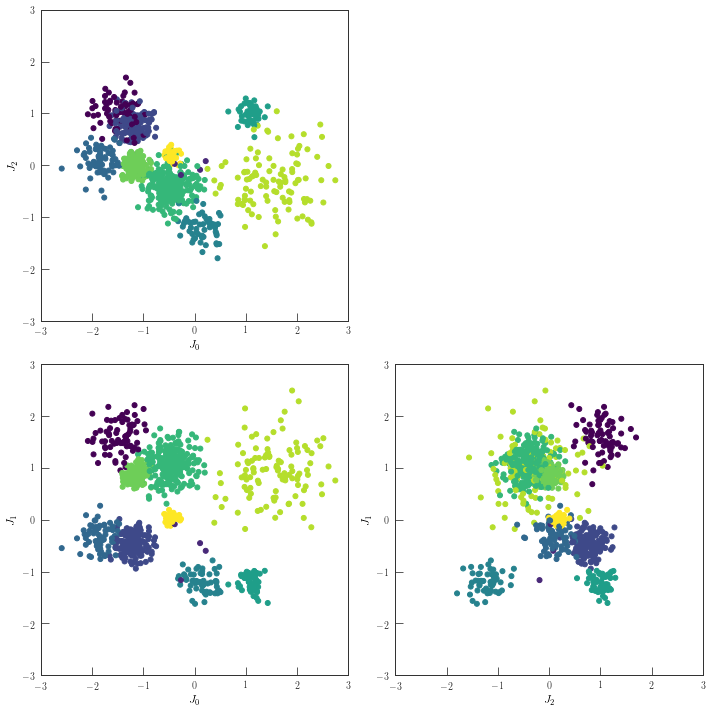

In [23]:
K = 2
fig, axes = plt.subplots(K, K, figsize=(10, 10))

axes[1, 0].scatter(truths["theta"].T[0], truths["theta"].T[1],
                   c=truths["responsibility"])
axes[1, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[1, 0].set_ylabel(r"$J_{{{0}}}$".format(1))

axes[0, 0].scatter(truths["theta"].T[0], truths["theta"].T[2],
                   c=truths["responsibility"])
axes[0, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[0, 0].set_ylabel(r"$J_{{{0}}}$".format(2))

axes[0, 1].set_visible(False)
axes[1, 1].scatter(truths["theta"].T[2], truths["theta"].T[1],
                   c=truths["responsibility"])
axes[1, 1].set_xlabel(r"$J_{{{0}}}$".format(2))
axes[1, 1].set_ylabel(r"$J_{{{0}}}$".format(1))

for ax in np.array(axes).flatten():
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
fig.tight_layout()


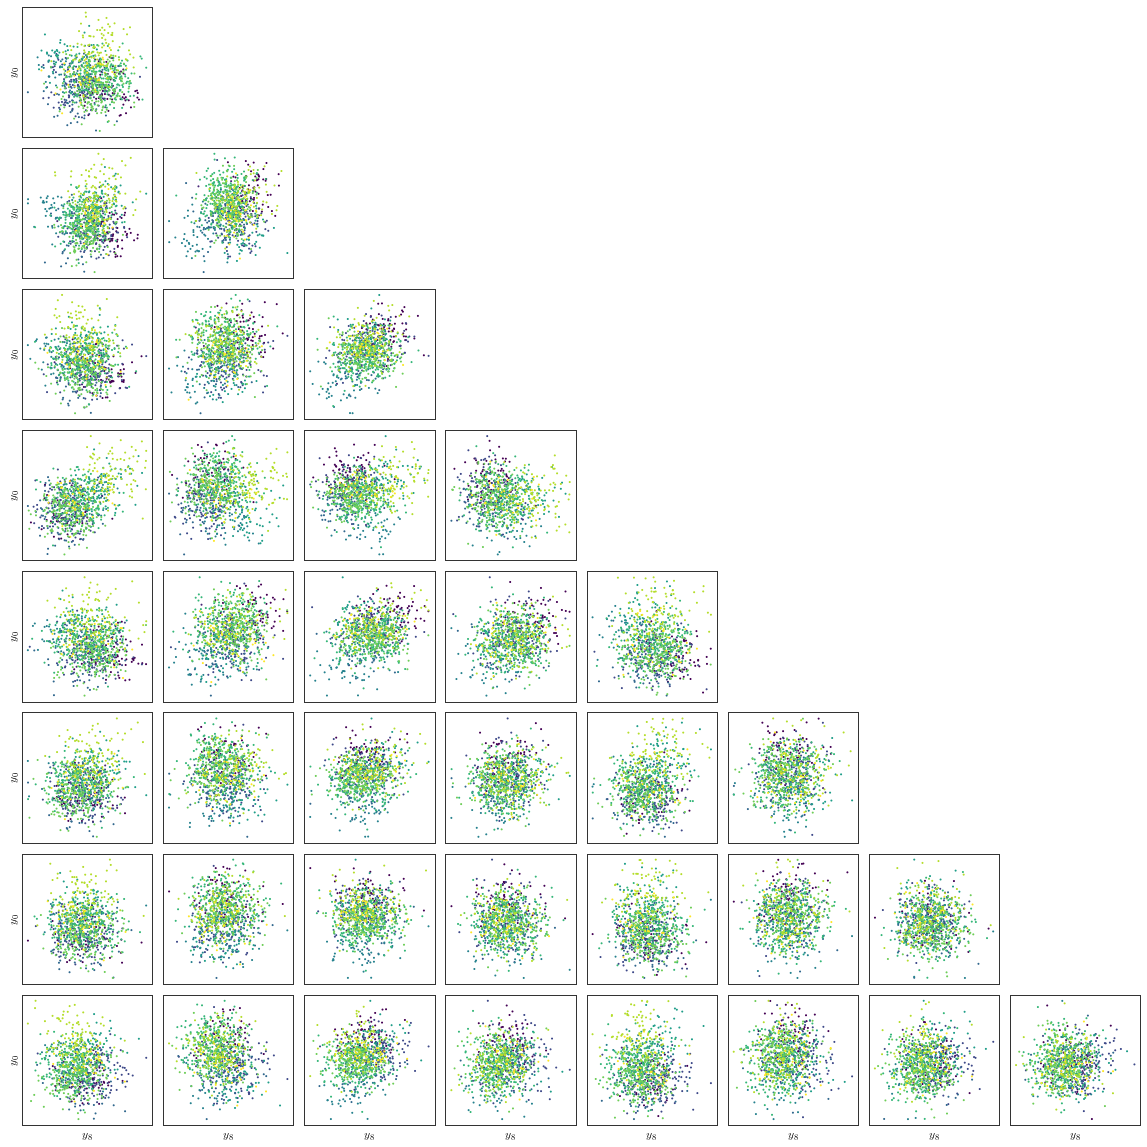

In [24]:
A = data["D"] - 1
fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

ordered = True

y = data["y"]

c = truths["responsibility"]    
indices = np.argsort(c) if ordered else np.arange(len(c))
kwds = dict(s=1, alpha=1, c=c[indices])


for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if j >= i:
            ax.set_visible(False)
            continue
            
        ax.scatter(y.T[i][indices], y.T[j][indices], **kwds)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if ax.is_last_row():
            ax.set_xlabel(r"$y_{{{0}}}$".format(i))
        if ax.is_first_col():
            ax.set_ylabel(r"$y_{{{0}}}$".format(j))
    
fig.tight_layout()


In [21]:
y.shape

(1000, 10)